In [2]:
# importing libraries and set standards
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import statistics as stat
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit

plt.rcParams['figure.figsize'] = 21, 15
plt.rcParams['xtick.labelsize']=65
plt.rcParams['ytick.labelsize']=65
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update({'figure.autolayout': False})
plt.rcParams['axes.linewidth'] = 5
plt.rcParams['font.family'] = 'Arial'

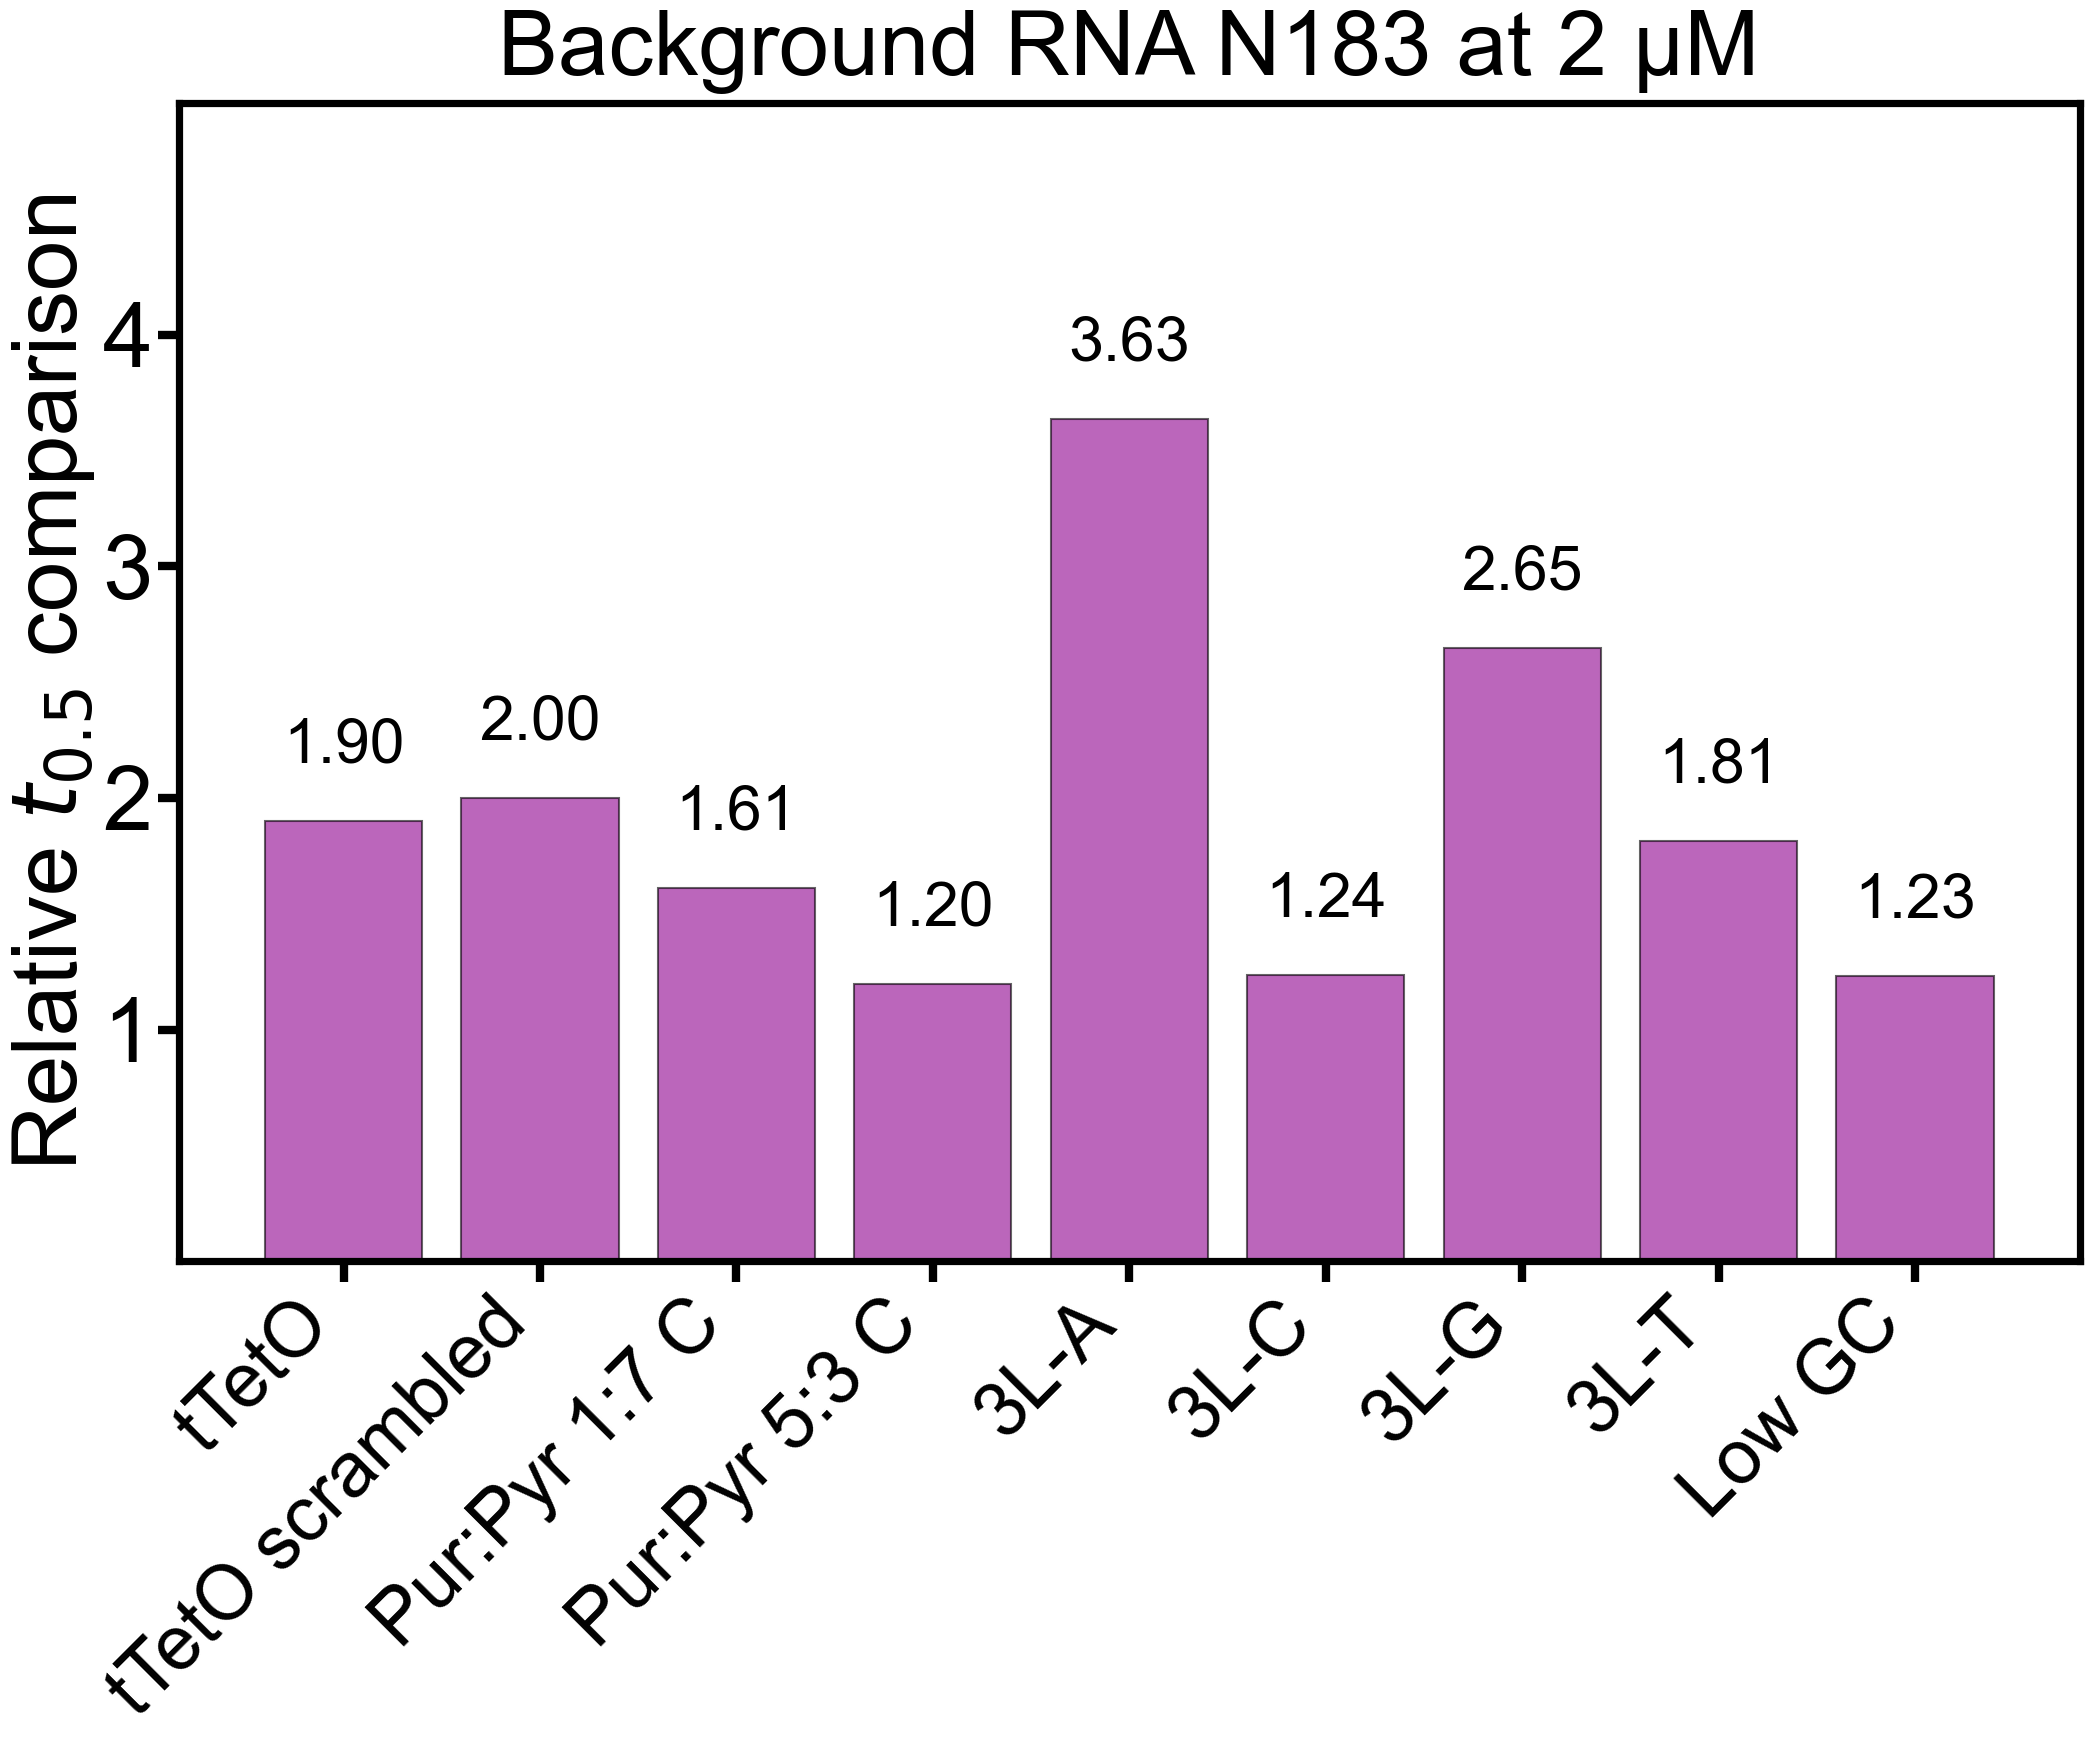

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
file_path = 'Figure3-RNA-Background.xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Extract relevant columns (all except 'time')
columns = data.columns[1:]

# Determine when each sample exceeds 100
time_to_threshold = {
    col.strip(): data[data[col] > 100].iloc[0]['time']
    if not data[data[col] > 100].empty else None
    for col in columns
}

# Normalize RNA samples to their matching reference
normalized_values = {}
reference_order = []

for col in columns:
    label = col.strip()
    if "RNA" in label:
        ref_label = label.replace("RNA", "").strip()
        rna_time = time_to_threshold.get(label)
        ref_time = time_to_threshold.get(ref_label)
        if ref_time is not None and rna_time is not None:
            normalized_values[label] = rna_time / ref_time
            if ref_label not in reference_order:
                reference_order.append(ref_label)

# Build bar data
ordered_labels = []
ordered_values = []

for ref in reference_order:
    rna_label = f"{ref} RNA"
    if rna_label in normalized_values:
        ordered_labels.append(rna_label)
        ordered_values.append(normalized_values[rna_label])

# Custom display labels
x_labels = [
    "tTetO", "tTetO scrambled", "Pur:Pyr 1:7 C", "Pur:Pyr 5:3 C",
    "3L-A", "3L-C", "3L-G", "3L-T", "Low GC"
]

# Plot
fig, ax = plt.subplots(figsize=(21, 17.5))
bars = ax.bar(
    x_labels,
    ordered_values,
    color='#8e008e',
    edgecolor='black',
    linewidth=1.5,
    alpha=0.6
)

# Value labels above bars
for bar, val in zip(bars, ordered_values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        val + 0.2,
        f"{val:.2f}",
        ha='center',
        va='bottom',
        fontsize=45,
        fontweight='bold'
    )

# Axis and ticks
ax.set_ylim([0, 5])
ax.set_yticks(np.arange(1, 5, 1))  # 1 to 4
ax.set_ylabel("Relative $t_{0.5}$ comparison", fontsize=65)
ax.tick_params(axis='both', which='major', length=15, width=6)
ax.tick_params(axis='y', labelsize=65)

# x-tick labels
ax.set_xticks(np.arange(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=55)

# Title
plt.title("Background RNA N183 at 2 µM", fontsize=65, weight='bold', pad=20)

# Border
plt.rcParams['axes.linewidth'] = 5.2

plt.tight_layout()
plt.savefig('Figure3_RNA_Background.svg', format='svg', dpi=300)
plt.show()
